# Wrap up quiz: Hyperparameter Tuning

In [ ]:
import pandas as pd

penguins = pd.read_csv("../datasets/penguins.csv")

columns = ["Body Mass (g)", "Flipper Length (mm)", "Culmen Length (mm)"]
target_name = "Species"

# Remove lines with missing values for the columns of interest
penguins_non_missing = penguins[columns + [target_name]].dropna()

data = penguins_non_missing[columns]
target = penguins_non_missing[target_name]

# goal: predict penguin species based on attributes stored in data
data.head()

,Body Mass (g),Flipper Length (mm),Culmen Length (mm)
0,3750.0,181.0,39.1
1,3800.0,186.0,39.5
2,3250.0,195.0,40.3
4,3450.0,193.0,36.7
5,3650.0,190.0,39.3


In [5]:
# q1
target.value_counts()

Species
Adelie Penguin (Pygoscelis adeliae)          151
Gentoo penguin (Pygoscelis papua)            123
Chinstrap penguin (Pygoscelis antarctica)     68
Name: count, dtype: int64

In [ ]:
# q1
target.info()

<class 'pandas.core.series.Series'>
Index: 342 entries, 0 to 343
Series name: Species
Non-Null Count  Dtype 
--------------  ----- 
342 non-null    object
dtypes: object(1)
memory usage: 5.3+ KB


In [8]:
# q1
target.nunique()

3

In [10]:
# q2
data.describe()

,Body Mass (g),Flipper Length (mm),Culmen Length (mm)
count,342.000000,342.000000,342.000000
mean,4201.754386,200.915205,43.921930
std,801.954536,14.061714,5.459584
min,2700.000000,172.000000,32.100000
25%,3550.000000,190.000000,39.225000
50%,4050.000000,197.000000,44.450000
75%,4750.000000,213.000000,48.500000
max,6300.000000,231.000000,59.600000


In [15]:
# q3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold

model = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])


# define a stratified 10-fold cross-validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform CV to assess our estimate of the variability of the generalisation performance of the model
cv_results = cross_validate(model, data, target, cv=cv, scoring="balanced_accuracy")
score = cv_results['test_score']
print(f"Mean: {score.mean():3f}, Std: {score.std():.3f}")

Mean: 0.950114, Std: 0.041


In [26]:
# q4 - comparing n_neigbors = 5 with n_neighbors = 51
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold

model_5_nn = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])

model_5_nn.set_params(classifier__n_neighbors=5)

# define a stratified 10-fold cv
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# perform cv
cv_results_5_nn = cross_validate(model_5_nn, data, target, cv=10, scoring="balanced_accuracy")
print(cv_results_5_nn['test_score'])
print()


model_51_nn = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])

model_51_nn.set_params(classifier__n_neighbors=51)

# perform cv
cv_results_51_nn = cross_validate(model_51_nn, data, target, cv=10, scoring="balanced_accuracy")
print(cv_results_51_nn['test_score'])


[1.         1.         1.         0.91880342 0.88253968 0.95238095
 0.97777778 0.93015873 0.90793651 0.95238095]

[0.95238095 0.97777778 1.         0.86324786 0.88253968 0.95238095
 0.95555556 0.95238095 0.93015873 0.95238095]


In [27]:
# q4 - comparing n_neigbors = 5 using standard scaler with n_neighbors = 5 without using standard scaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold

model_scale = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])

model.set_params(preprocessor=StandardScaler(), classifier__n_neighbors=51)
cv_results_ss_51 = cross_validate(
    model, data, target, cv=10, scoring="balanced_accuracy"
)
cv_results_ss_51["test_score"].mean(), cv_results_ss_51["test_score"].std()

(np.float64(0.9418803418803419), np.float64(0.03890547525064432))

5-NN is strictly better than 51-NN for 4 CV iterations out of 10.


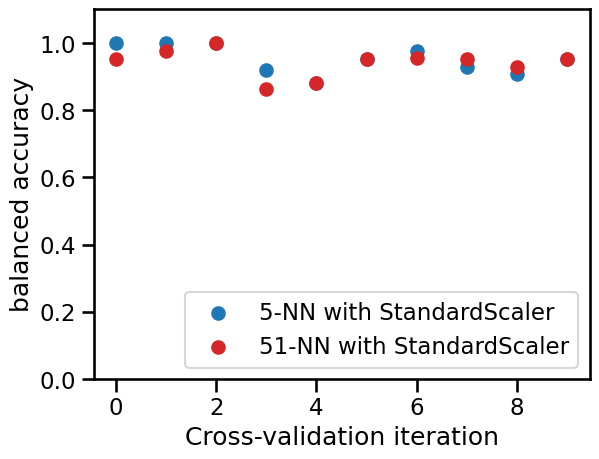

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

test_score_ss_5 = cv_results_ss_5['test_score']
test_score_ss_51 = cv_results_ss_51['test_score']

indices = np.arange(len(test_score_ss_5))
plt.scatter(
    indices,
    test_score_ss_5,
    color="tab:blue",
    label="5-NN with StandardScaler",
)
plt.scatter(
    indices,
    test_score_ss_51,
    color="tab:red",
    label="51-NN with StandardScaler",
)
plt.ylim((0, 1.1))
plt.xlabel("Cross-validation iteration")
plt.ylabel("balanced accuracy")
_ = plt.legend(loc="lower right")

print(
    "5-NN is strictly better than 51-NN for "
    f"{sum(test_score_ss_5 > test_score_ss_51)}"
    " CV iterations out of 10."
)

Use sklearn.model_selection.GridSearchCV to study the impact of the choice of the preprocessor and the number of neighbors on the stratified 10-fold cross-validated balanced_accuracy metric. We want to study the n_neighbors in the range [5, 51, 101] and preprocessor in the range all_preprocessors. Although we wouldn't do this in a real setting (and prefer using nested cross validation), for this question, do the cross-validation on the entire dataset.

In [ ]:
# q5
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# building model pipeline
model = Pipeline(steps=[
    ("preprocessor", None),
    ("classifier", KNeighborsClassifier(n_neighbors=5)),
])

# identifying all parameters possible
for param in model.get_params():
    print(param)

memory
steps
transform_input
verbose
preprocessor
classifier
classifier__algorithm
classifier__leaf_size
classifier__metric
classifier__metric_params
classifier__n_jobs
classifier__n_neighbors
classifier__p
classifier__weights


In [60]:
all_preprocessors = [
    None,
    StandardScaler(),
    MinMaxScaler(),
    QuantileTransformer(n_quantiles=100),
    PowerTransformer(method="box-cox"),
]

param_grid = {
    'preprocessor': all_preprocessors,
    'classifier__n_neighbors': [5, 51, 101]
}

model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=10, scoring="balanced_accuracy")
model_grid_search.fit(data, target)

# reformatting cv_results
results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    by="rank_test_score", ascending=True
)
# convert the name of the preprocessor for later display
results["param_preprocessor"] = results["param_preprocessor"].apply(
    lambda x: x.__class__.__name__ if x is not None else "None"
)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_preprocessor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.001207,0.000168,0.001725,0.000215,5,StandardScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,1.000000,1.000000,0.918803,0.882540,0.952381,0.977778,0.930159,0.907937,0.952381,0.952198,0.039902,1
2,0.001088,0.000162,0.001525,0.000104,5,MinMaxScaler,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.952381,1.000000,0.944444,0.882540,0.930159,0.955556,0.952381,0.907937,0.952381,0.947778,0.034268,2
3,0.002076,0.000180,0.001639,0.000087,5,QuantileTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",0.952381,0.926740,1.000000,0.918803,0.904762,1.000000,0.977778,0.930159,0.907937,0.952381,0.947094,0.033797,3
4,0.012487,0.002005,0.001718,0.000091,5,PowerTransformer,"{'classifier__n_neighbors': 5, 'preprocessor':...",1.000000,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.930159,0.907937,1.000000,0.946960,0.047387,4
6,0.001101,0.000115,0.001623,0.000036,51,StandardScaler,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.952381,0.977778,1.000000,0.863248,0.882540,0.952381,0.955556,0.952381,0.930159,0.952381,0.941880,0.038905,5
8,0.002010,0.000104,0.001710,0.000098,51,QuantileTransformer,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.857143,0.952381,1.000000,0.863248,0.904762,0.904762,0.977778,0.930159,0.930159,0.952381,0.927277,0.043759,6
9,0.012470,0.001917,0.001874,0.000122,51,PowerTransformer,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.977778,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.922833,0.047883,7
7,0.001026,0.000045,0.001634,0.000073,51,MinMaxScaler,"{'classifier__n_neighbors': 51, 'preprocessor'...",0.904762,0.952381,1.000000,0.863248,0.834921,0.952381,0.907937,0.952381,0.930159,0.904762,0.920293,0.045516,8
11,0.001048,0.000045,0.001752,0.000126,101,StandardScaler,"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.952381,0.944444,0.863248,0.834921,0.857143,0.834921,0.882540,0.834921,0.904762,0.876642,0.041618,9
12,0.001012,0.000017,0.001714,0.000104,101,MinMaxScaler,"{'classifier__n_neighbors': 101, 'preprocessor...",0.857143,0.857143,0.944444,0.863248,0.834921,0.857143,0.765079,0.904762,0.834921,0.904762,0.862357,0.046244,10


Evaluate the generalization performance of the best models found in each fold using nested cross-validation. Set return_estimator=True and cv=10 for the outer loop. The scoring metric must be the balanced-accuracy.

The mean generalization performance is :

In [67]:
# q6

all_preprocessors = [
    None,
    StandardScaler(),
    MinMaxScaler(),
    QuantileTransformer(n_quantiles=100),
    PowerTransformer(method="box-cox"),
]

param_grid = {
    'preprocessor': all_preprocessors,
    'classifier__n_neighbors': [5, 51, 101]
}

model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=10, scoring="balanced_accuracy")
model_grid_search.fit(data, target)

cv_results = cross_validate(
    model_grid_search, data, target, cv=10, scoring="balanced_accuracy", return_estimator=True
)
print(f"The mean generalisation performance for the best model in each fold is: {cv_results['test_score'].mean():.3f}")

The mean generalisation performance for the best model in each fold is: 0.943


In [72]:
# q7
for cv_fold, estimator_in_fold in enumerate(cv_results['estimator']):
    print(
        f"Best hyperparameters for fold #{cv_fold+1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Best hyperparameters for fold #2:
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Best hyperparameters for fold #3:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #4:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #5:
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
Best hyperparameters for fold #6:
{'classifier__n_neighbors': 5, 'preprocessor': QuantileTransformer(n_quantiles=100)}
Best hyperparameters for fold #7:
{'classifier__n_neighbors': 5, 'preprocessor': MinMaxScaler()}
Best hyperparameters for fold #8:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #9:
{'classifier__n_neighbors': 5, 'preprocessor': StandardScaler()}
Best hyperparameters for fold #10:
{'classifier__n_ne